#### COMP 215 - Project 02

# Extending the Forest Fire Model

#### Name: Ben Blair
#### Date: 13/04/2023

## Background:

In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modeled: forest regeneration, fire ignition, and fire spread.

* Empty cells "regenerate" forest at a fixed rate, $p$
* Forest fires ignite with a regular but small frequency, $f$
* Forested cells catch fire when their neighbours are burning, and burn out in one time step

## Project Description:

The purpose of this project was to extend the simplified forest fire model developed in Labs 7-10. In the extended forest fire model:

* Forested cells regenerate in empty cells at a fixed rate, $r$
* Forested cells ignite spontaneously with a small frequency, $f$
* Forested cells *may* ignite when their neighbours are on fire, but the ignition probability depends on the relative elevation of the forested cell:
    * forested cells at the **same elevation** ignite with probability, $p$
    * forested cells at a **higher elevation** than a burning neighbour ignite with probability, $p + (p * $`elev_factor`$)$
    * forested cells at **lower elevation** ignite with probability, $p - (p * $`elev_factor`$)$

The extended forest fire model was compared to the simplified forest fire model to determine how the modifications would affect the behaviour of the model.

## Setting up the project notebook

### Import the necessary modules

The first code block is copied from Lab 7-10 and imports all of the necessary modules and packages to ensure everything works as expected.

In [1]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Define some helper functions

The next couple of code blocks are copied from Lab 7-10 and define some functions which will help visualize what's going on in the model.

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Building the ForestFire model

### Starting with the basics

Most of the ForestFire model can be copied from Lab 7-10. However, the step function in the extended forest fire model will be more complicated. An initial model was constructed with just the basics:

* A forest cell burns if any of its neighbors is on fire (this rule will need to be updated later).
* A forested cell spontaneously burns with probability, $f$, even if none of its neighbors is on fire.
* A cell that is on fire becomes an empty cell in the next time step.
* An empty cell becomes forested with probability, $r$.

The probabilities will be given default values of $r=0.01$ and $f=0.001$.

**Note**: Most of the following code block was copied from the ForestFire class used in Lab 7-10, but some modifications have been made.

In [4]:
class ForestFire:
    """ A 2D cellular automaton that simulates fire in a forested landscape. """
    
    # Define the 3 possible cell states
    EMPTY = 0
    FOREST = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(0, 0, 0)] * 6
    cmap[EMPTY] = (0.5, 0.3, 0)   # brown
    cmap[FOREST] = (0.3, 0.6, 0)  # green
    cmap[FIRE] = (0.9, 0, 0)      # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Define the correlation kernel
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    def __init__(self, n, q=0.5, r=0.01, f=0.001):
        """
        Initializes the ForestFire model.

        n: Number of rows/columns
        q: Probability of generating a forested cell in initial state
        r: Probability of forest regeneration in empty cells
        f: Probability of spontaneous ignition in forested cells

        """
        self.shape = (n, n)

        self.r = r
        self.f = f

        # Build an nxn landscape with probability q that each cell is forested
        self.state = np.random.choice([self.FOREST, self.EMPTY], self.shape, p=[q, 1-q])
    

    def step(self):
        """
        Moves the model forward one time step.

        """
        # Get boolean arrays of empty, forested, and burning cells
        empty = self.state == self.EMPTY
        forested = self.state == self.FOREST
        on_fire = self.state == self.FIRE

        # Rule 1: A forested cell may ignite if one of neighbours is on fire
        neighbourhood = correlate2d(self.state, self.kernel, mode='same')  # removed boundary='wrap'
        at_risk = forested & (neighbourhood >= self.FIRE)
        self.state[at_risk] = self.FIRE

        # TODO: Update Rule 1
        # Ignition probability should depend on relative elevation of forested and fire cells

        # Rule 2: A forested cell may ignite spontaneously with probability, f
        forested = self.state == self.FOREST  # update boolean array of forested cells
        self.state[forested] = np.random.choice(
            [self.FIRE, self.FOREST],
            self.state[forested].shape,
            p=[self.f, 1-self.f]
        )

        # Rule 3: A cell that is on fire becomes empty in the next time step
        self.state[on_fire] = self.EMPTY

        # Rule 4: An empty cell may become forested with probability, r
        self.state[empty] = np.random.choice(
            [self.FOREST, self.EMPTY],
            self.state[empty].shape,
            p=[self.r, 1-self.r]
        )


    def num_occupied(self):
        """ Return the number of cells occupied by fores. """
        n_occupied = np.sum(self.state == self.FOREST)
        return n_occupied


    def pct_occupied(self):
        """ Return the proportion of cells occupied by forest. """
        pct_occupied = self.num_occupied() / self.state.size
        return pct_occupied


    def draw(self, axes=None, step=''):
        """ Draws the CA cells using the forest colour map so values are coloured intuitively. """
        axes = axes or plt.gca()
        title = f'Time: {step}, Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.state, axes=axes, title=title,
                    cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

### Testing the initial model

A small forest fire can be constructed to ensure the model is functioning as expected.

In [5]:
# Create a small test model with inflated regeneration and spontaneous ignition probabilities
ff_test = ForestFire(5, r=0.3, f=0.1)
ff_test.state[2,2] = 5
print(ff_test.state)

# Run the test model for 3 time steps
for _ in range(3):
    ff_test.step()
    print(ff_test.state)

[[1 0 0 0 0]
 [0 0 1 0 1]
 [0 0 5 1 0]
 [0 0 1 1 0]
 [0 0 0 0 0]]
[[5 1 0 1 0]
 [0 1 5 1 1]
 [0 0 0 5 0]
 [0 1 5 1 0]
 [0 1 0 0 1]]
[[0 5 0 5 0]
 [0 5 0 5 5]
 [0 1 0 0 0]
 [0 5 0 5 0]
 [0 1 1 1 1]]
[[1 0 0 0 0]
 [0 0 1 0 0]
 [1 5 1 0 0]
 [1 0 0 0 0]
 [0 5 1 5 1]]


### Building the elevation map

Before updating Rule 1 in the ForestFire model's `step()` method, the elevation data for the landscape must be defined. For this project, a 2D array with the same dimensions as the ForestFire was used to store the elevation data.

To start, an elevation map with a constant linear slope was created. However, more varied elevation data could be implemented in the future.

In [6]:
n = 5

# Build a 1D array representing the horizontal elevation of the landscape
h_elev = np.linspace(0, n-1, n, dtype=int)
print(h_elev)

# Extend the slope to create an nxn 2D array
elev_map = np.full((n, n), h_elev)
print(elev_map)

[0 1 2 3 4]
[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


The elevation map above slopes upwards from left to right (i.e., elevation increases as the number increases with 0 representing sea level).

Now, the code can be packaged into a function for convenience.

In [7]:
def lin_slope(n, slope=1):
    """ Generate an elevation map with a linear slope. """
    h_elev = np.linspace(0, slope*(n-1), n, dtype=int)
    elev_map = np.full((n, n), h_elev)
    return elev_map

elev_map = lin_slope(10, 3)
print(elev_map)

[[ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  3  6  9 12 15 18 21 24 27]]


### Unpacking the fire spreading algorithm

Next, the fire spreading algorithm needs to be updated. In the extended forest fire model, forested cells are not guaranteed to catch fire when one of their neighbouring cells is on fire. Instead, the new algorithm should compute the ignition probability of a forested cell based on a base probability and the difference in elevation between the forested cell and the cell that is on fire.

One way to accomplish this task is to identify all cells that are on fire in the current time step then loop through each of those cells one by one and calculate the probability of the fire spreading to each cell's neighbours. This method was attempted below.



In [8]:
# Define the cell states
EMPTY = 0
FOREST = 1
FIRE = 5

# Define key parameters 
n = 5    # number rows/columns
q = 0.5  # initial forest density
p = 0.7  # probability of fire spreading to cells at same elevation

# Define the correlation kernel
kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

# Initialize the landscape
state = np.random.choice([FOREST, EMPTY], (n, n), p=[q, 1-q])

# Ignite a few cells to test the algorithm
state[1, 1] = FIRE
state[2, 2] = FIRE
state[3, 3] = FIRE
print(state)

# Generate the elevation map
elevation = lin_slope(n)

# Get boolean arrays of the cell states
forested = state == FOREST
on_fire = state == FIRE

# Determine which cells are at-risk of catching fire
neighbourhood = correlate2d(state, kernel, mode='same')
at_risk = forested & (neighbourhood >= FIRE)

# Get the array indexes of all cells on fire
fire_ids = np.nonzero(on_fire)

# Unpack the array ids into a list of tuples with the form (row, col)
element_ids = list(zip(fire_ids[0], fire_ids[1]))

# Loop through each cell on fire to determine fire spread
for element in element_ids:

    # Unpack the row, col indexes
    i, j = element

    # Get the elevation of each neighbouring cell
    top = elevation[i-1, j]
    right = elevation[i, j+1]
    bottom = elevation[i+1, j]
    left = elevation[i, j-1]    

    # Store the cardinal elevations in an array and compute the relative differences
    cardi_es = np.array([top, right, bottom, left])
    elev_diffs = cardi_es - elevation[i, j]

    # Compute the ignition probability for each neighbouring cell
    ig_probs = p + (elev_diffs * 0.3 * p)

    # Determine which cells catch fire using the computed ignition probabilities
    if state[i-1, j] == 1:
        state[i-1, j] = np.random.choice([5, 1], p=[ig_probs[1], 1-ig_probs[1]])  # top
    if state[i, j+1] == 1:
        state[i, j+1] = np.random.choice([5, 1], p=[ig_probs[0], 1-ig_probs[0]])  # right
    if state[i+1, j] == 1:
        state[i+1, j] = np.random.choice([5, 1], p=[ig_probs[3], 1-ig_probs[3]])  # bottom
    if state[i, j-1] == 1:
        state[i, j-1] = np.random.choice([5, 1], p=[ig_probs[2], 1-ig_probs[2]])  # left

print(state)

[[1 1 1 0 1]
 [1 5 0 0 1]
 [0 0 5 0 0]
 [1 0 0 5 1]
 [1 0 1 0 0]]
[[1 1 1 0 1]
 [5 5 0 0 1]
 [0 0 5 0 0]
 [1 0 0 5 1]
 [1 0 1 0 0]]


While the above algorithm seemed to work okay, it didn't feel quite right. For instance, it eliminates the need for the correlation kernel and does not make use of the `at_risk` array.

A second approach to implementing the new fire spreading algorithm was ultimately selected. Instead of looping through each cell that is on fire, this approach loops through each at-risk cell and calculates the probability of that cell catching fire using the following formula:

> $P(T ∪ R ∪ B ∪ L) = P(T) + P(R) + P(B) + P(L) - P(T ∩ R) - P(T ∩ B) - P(T ∩ L) - P(R ∩ B) - P(R ∩ L) - P(B ∩ L) + P(T ∩ R ∩ B) + P(T ∩ R ∩ L) + P(T ∩ B ∩ L) + P(R ∩ B ∩ L) - P(T ∩ R ∩ B ∩ L)$

where $P(T)$ is the probability of a cell catching fire from its **top** neighbour, $P(R)$ is the probability of a cell catching fire from its **right** neighbour, $P(B)$ is the probability of a cell catching fire from its **bottom** neighbour, and $P(L)$ is the probability of a cell catching fire from its **left** neighbour.


Despite the horrific formula, the implementation of this approach is quite similar and feels more logical.

In [9]:
# Define the cell states
EMPTY = 0
FOREST = 1
FIRE = 5

# Define key parameters
n = 5    # number rows/columns
q = 0.5  # initial forest density
p = 0.7  # probability of fire spreading to cells at same elevation

# Define the correlation kernel
kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

# Initialize the landscape
state = np.random.choice([FOREST, EMPTY], (n, n), p=[q, 1-q])

# Ignite a few cells to test the algorithm
state[1, 1] = 5
state[2, 2] = 5
state[3, 3] = 5
print(state)

# Generate the elevation map
elevation = lin_slope(n)

# Get boolean arrays of the cell states
forested = state == FOREST
on_fire = state == FIRE

# Determine which cells are at-risk of catching fire
neighbourhood = correlate2d(state, kernel, mode='same')
at_risk = forested & (neighbourhood >= FIRE)

# Get the indexes of all at-risk cells
risk_ids = np.argwhere(at_risk)

# Create an array to store the ignition probability for each at-risk cell
ig_probs = np.zeros((n, n))

for id in risk_ids:    
    # Store cell index
    cell = tuple(id)

    # Adjust row, column indexes to account for array padding in next steps
    row, col = id + 1

    # Pad the state map with 0s
    state_pad = np.pad(state.copy(), 1)

    # Get the state of each neighbouring cell
    hood_states = np.array([
        state_pad[row-1, col],  # top
        state_pad[row, col+1],  # right
        state_pad[row+1, col],  # bottom
        state_pad[row, col-1],  # left
    ])

    # Pad the elevation map with 0s
    elev_pad = np.pad(elevation.copy(), 1)

    # Get the elevation of each neighbouring cell
    hood_elevs = np.array([
        elev_pad[row-1, col],  # top
        elev_pad[row, col+1],  # right
        elev_pad[row+1, col],  # bottom
        elev_pad[row, col-1],  # left
    ])

    # Calculate the changes in elevation compared to the central cell
    elev_diffs = elevation[cell] - hood_elevs

    # Calculate the ignition probability from each neighbour based on the elevation changes
    elev_probs = p + ((0.3 * p) * elev_diffs)

    # Filter elevation probabilities by neighbourhood states
    elev_probs[hood_states != FIRE] = 0

    # Calculate the combined ignition probability using the following formula:
    # P(t ∪ r ∪ b ∪ l) = P(t) + P(r) + P(b) + P(l) - P(t ∩ r) - P(t ∩ b) - P(t ∩ l) - P(r ∩ b) - P(r ∩ l) - P(b ∩ l) + P(t ∩ r ∩ b) + P(t ∩ r ∩ l) + P(t ∩ b ∩ l) + P(r ∩ b ∩ l) - P(t ∩ r ∩ b ∩ l)
    pt, pr, pb, pl = elev_probs

    ptr = pt * pr
    ptb = pt * pb
    ptl = pt * pl
    prb = pr * pb
    prl = pr * pl
    pbl = pb * pl
    ptrb = pt * pr * pb
    ptrl = pt * pr * pl
    ptbl = pt * pb * pl
    prbl = pr * pb * pl
    ptrbl = pt * pr * pb * pl
    
    p_ignition = pt + pr + pb + pl - ptr - ptb - ptl - prb - prl - pbl + ptrb + ptrl + ptbl + prbl - ptrbl

    # Store the ignition probability for each cell in ig_probs
    ig_probs[cell] = p_ignition

    # Determine which cells catch fire and update the model state
    state[cell] = np.random.choice([FIRE, FOREST], p=[p_ignition, 1-p_ignition])

print(ig_probs)

[[0 0 1 0 1]
 [1 5 0 1 1]
 [1 0 5 0 1]
 [1 1 0 5 0]
 [1 1 0 1 1]]
[[0.   0.   0.   0.   0.  ]
 [0.49 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.7  0.  ]]


### Update the ForestFire class

Now, the new fire spreading algorithm can be incorporated into the ForestFire class.

**Note**: The formula that was used to calculate the `elev_probs` on line 77 in the code block above was not quite right so it has been modified in the updated class below. Unfortunately, when the new formula provided a `p_ignition = 1.0`, the complementary probability calculated by `1-p_ignition` on line 137 was occassionally negative. Therefore, `abs(1-p_ignition)` was used. 

In [10]:
class ExtForestFire:
    """ A 2D cellular automaton that simulates fire in a forested landscape. """
    
    # Define the 3 possible cell states
    EMPTY = 0
    FOREST = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(0, 0, 0)] * 6
    cmap[EMPTY] = (0.5, 0.3, 0)   # brown
    cmap[FOREST] = (0.3, 0.6, 0)  # green
    cmap[FIRE] = (0.9, 0, 0)      # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Define the correlation kernel
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    def __init__(self, n, q=0.5, p=0.7, r=0.01, f=0.001, elev_map=None, elev_factor=0.3):
        """
        Initializes the ForestFire model.

        n: Number of rows/columns
        q: Probability of generating a forested cell in initial state
        p: Probability of ignition from neighbours at same elevation
        r: Probability of forest regeneration in empty cells
        f: Probability of spontaneous ignition in forested cells

        elev_map: An nxn array containing elevation data for each cell
        elev_factor: Factor by which to adjust probability of ignition, p

        """
        self.shape = (n, n)

        self.p = p
        self.r = r
        self.f = f

        # Build an nxn landscape with probability q that each cell is forested
        self.state = np.random.choice([self.FOREST, self.EMPTY], self.shape, p=[q, 1-q])

        # Store the given elevation map or generate a uniform elevation map
        if np.any(elev_map):
            self.elev = elev_map
        else:
            self.elev = np.ones(self.shape, dtype=int)  # Generate a uniform elevation map

        self.elev_f = elev_factor

        # Combine the state and elevation layers to build a complete model
        self.model = np.stack((self.state, self.elev))


    def step(self):
        """
        Moves the model forward one time step.

        """
        # Get boolean arrays of empty, forested, and burning cells
        empty = self.state == self.EMPTY
        forested = self.state == self.FOREST
        on_fire = self.state == self.FIRE

        # Rule 1: A forested cell may ignite if one of neighbours is on fire
        neighbourhood = correlate2d(self.state, self.kernel, mode='same')  # removed boundary='wrap'
        at_risk = forested & (neighbourhood >= self.FIRE)

        # Get the indexes of all at-risk cells
        risk_ids = np.argwhere(at_risk)

        # Compute ignition probability for each at-risk cell
        for id in risk_ids:    
            # Store cell index
            cell = tuple(id)

            # Adjust row, column indexes to account for array padding in next steps
            row, col = id + 1

            # Pad the state map with 0s
            state_pad = np.pad(self.state.copy(), 1)

            # Get the state of each neighbouring cell
            hood_states = np.array([
                state_pad[row-1, col],  # top
                state_pad[row, col+1],  # right
                state_pad[row+1, col],  # bottom
                state_pad[row, col-1],  # left
            ])

            # Pad the elevation map with 0s
            elev_pad = np.pad(self.elev.copy(), 1)

            # Get the elevation of each neighbouring cell
            hood_elevs = np.array([
                elev_pad[row-1, col],  # top
                elev_pad[row, col+1],  # right
                elev_pad[row+1, col],  # bottom
                elev_pad[row, col-1],  # left
            ])

            # Calculate the changes in elevation compared to the central cell
            elev_diffs = self.elev[cell] - hood_elevs

            # Extract the sign and value from each elevation difference
            signs, vals = np.sign(elev_diffs), abs(elev_diffs)

            # Calculate the ignition probability from each neighbour based on the elevation changes
            elev_probs = self.p * (1 + (self.elev_f * signs))**vals  # increase/decrease the probability by 30% per unit change in elevation
            elev_probs[elev_probs > 1] = 1  # set any probabilities >1 to 1

            # Filter elevation probabilities by neighbourhood states
            elev_probs[hood_states != self.FIRE] = 0

            # Calculate the combined ignition probability using the following formula:
            # P(t ∪ r ∪ b ∪ l) = P(t) + P(r) + P(b) + P(l) - P(t ∩ r) - P(t ∩ b) - P(t ∩ l) - P(r ∩ b) - P(r ∩ l) - P(b ∩ l) + P(t ∩ r ∩ b) + P(t ∩ r ∩ l) + P(t ∩ b ∩ l) + P(r ∩ b ∩ l) - P(t ∩ r ∩ b ∩ l)
            pt, pr, pb, pl = elev_probs

            ptr = pt * pr
            ptb = pt * pb
            ptl = pt * pl
            prb = pr * pb
            prl = pr * pl
            pbl = pb * pl
            ptrb = pt * pr * pb
            ptrl = pt * pr * pl
            ptbl = pt * pb * pl
            prbl = pr * pb * pl
            ptrbl = pt * pr * pb * pl
            
            p_ignition = pt + pr + pb + pl - ptr - ptb - ptl - prb - prl - pbl + ptrb + ptrl + ptbl + prbl - ptrbl

            # Determine which cells catch fire and update the model state
            self.state[cell] = np.random.choice([self.FIRE, self.FOREST], p=[p_ignition, abs(1-p_ignition)])  # take absolute value to avoid negative probabilities when p_ignition = 1.0

        # Rule 2: A forested cell may ignite spontaneously with probability, f
        forested = self.state == self.FOREST  # update boolean array of forested cells
        self.state[forested] = np.random.choice(
            [self.FIRE, self.FOREST],
            self.state[forested].shape,
            p=[self.f, 1-self.f]
        )

        # Rule 3: A cell that is on fire becomes empty in the next time step
        self.state[on_fire] = self.EMPTY

        # Rule 4: An empty cell may become forested with probability, r
        self.state[empty] = np.random.choice(
            [self.FOREST, self.EMPTY],
            self.state[empty].shape,
            p=[self.r, 1-self.r]
        )


    def num_occupied(self):
        """ Return the number of cells occupied by fores. """
        n_occupied = np.sum(self.state == self.FOREST)
        return n_occupied


    def pct_occupied(self):
        """ Return the proportion of cells occupied by forest. """
        pct_occupied = self.num_occupied() / self.state.size
        return pct_occupied


    def draw(self, axes=None, step=''):
        """ Draws the CA cells using the forest colour map so values are coloured intuitively. """
        axes = axes or plt.gca()
        title = f'Time: {step}, Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.state, axes=axes, title=title,
                    cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

### Test the extended ForestFire class

Once again, a small forest fire can be created to test the newly updated model.

In [11]:
# Generate an elevation map
elevation = lin_slope(5)

# Create a small test model with inflated regeneration and spontaneous ignition probabilities
ff_test = ExtForestFire(5, r=0.1, f=0.1, elev_map=elevation)
ff_test.state[2,2] = 5
print(ff_test.state)

# Run the test model for 3 time steps
for _ in range(3):
    ff_test.step()
    print(ff_test.state)

[[1 1 1 0 1]
 [0 1 0 1 0]
 [0 0 5 0 0]
 [0 1 0 0 1]
 [0 0 1 0 0]]
[[1 1 1 1 1]
 [0 1 0 1 1]
 [0 0 0 0 0]
 [0 1 0 0 1]
 [0 0 1 1 0]]
[[1 1 1 1 1]
 [0 1 0 1 1]
 [0 0 0 0 0]
 [0 1 0 0 1]
 [0 0 1 1 0]]
[[1 1 1 1 1]
 [0 1 0 1 1]
 [0 0 0 0 0]
 [0 1 0 0 1]
 [0 0 1 1 0]]


The small test model appears to be working as expected.

An animation can be used to visualize a larger test model, which will make it easier to see what's going on.

In [12]:
# Generate an elevation map
elevation = lin_slope(21)

# Generate the model
ff_test = ExtForestFire(21, elev_map=elevation)

# Generate the animation
ff_anim = Animation2D(ff_test, frames=25)
ff_anim.show()

To get a better sense of the effect of the elevation on the spread of the fire, the initial state of the model can be manipulated before animating.

In [13]:
# Make every cell forested and ignite the middle column
ff_test.state[:, :] = 1
ff_test.state[:, 10] = 5

# Generate the animation
fire_anim = Animation2D(ff_test, frames=25)
fire_anim.show()

In this animation, it can clearly be seen that the fire is spreading more efficiently towards the right side of the forest. This is exactly what is expected. Recall, the `lin_slope()` function generates elevation data representing a linear slope to the right and the updated fire spreading algorithm increases the ignition probability of forested cells that are higher in elevation than their burning neighbours.

## Analyzing the extended forest fire model

The next step is to ivestigate how the extended forest fire model behaves differently from the simplified model developed in Labs 7-10.

### Finding the steady state

To determine the "steady state" of the extended forest fire model, the model will be run for a given number of time steps and the number of forested cells will be plotted over time.

A function can be developed to make things a little bit easier.

In [14]:
def fire_sim(model, steps=500):

    timestep = 0
    history = []
    attractor = 0
    
    # Run the model for the given number of time steps
    for _ in range(steps):
        model.step()
        history.append(model.num_occupied())
    
    # Keep track of the timesteps in the models history
    timestep += steps
    
    # Calculate the attractor value based on the most recent 25% of timesteps
    attractor = np.average(history[-(steps//4):])

    # Define the fig, ax for the plot
    fig, ax = plt.subplots(layout='constrained')

    # Plot number of forested cells over time
    ax.plot(range(timestep), history)
    ax.set_xlabel('# of steps')
    ax.set_ylabel('# of forested cells')
    
    # Define functions for secondary y-axis
    def num_to_pct(y):
        return (y / model.state.size) * 100
    
    def pct_to_num(y):
        return (y / 100) * model.state.size

    # Add a secondary y-axis for the % of forested cells
    sec_ax = ax.secondary_yaxis('right', functions=(num_to_pct, pct_to_num))
    sec_ax.set_ylabel('% of forested cells')

    # Add horizontal line at "attractor" value
    ax.axhline(attractor, color='r', linestyle=':')

    # Display attractor as number and percentage of forested cells
    ax.set_title(f'Attractor: {attractor:.0f} ({num_to_pct(attractor):.2f}%)')

    plt.show()

Now the "steady state" of the simplified forest fire model can be determined (as seen in Lab 7-10) by setting the fire spreading probability to 1.0 and not providing an elevation map...

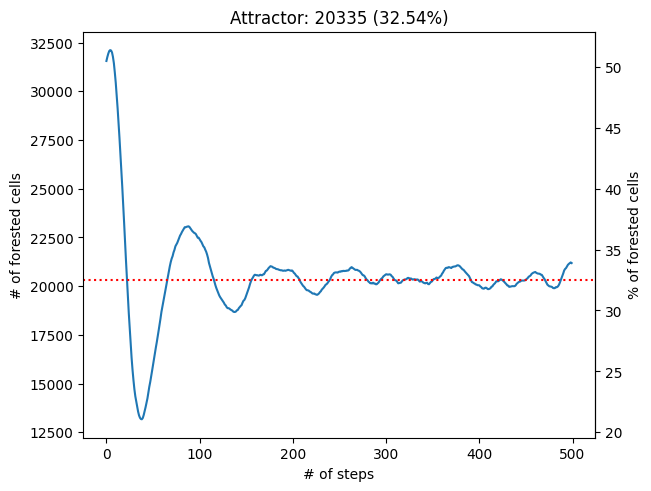

In [15]:
# Generate a simple forest fire model
simple_ff = ExtForestFire(250, p=1.0)

# Run a forest fire simulation to determine the steady state
fire_sim(simple_ff)

Then the fire spreading probability can be reduced to 0.7 to see the effect on the "steady state" of the model...

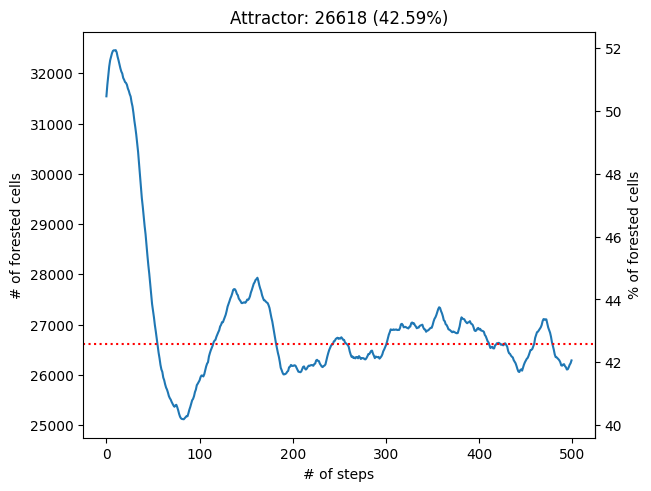

In [16]:
# Generate a simple forest fire model
simple_ff_reduced_p = ExtForestFire(250, p=0.7)

# Run a forest fire simulation to determine the steady state
fire_sim(simple_ff_reduced_p)

Finally the "steady state" of the extended model can be determined by leaving the model parameters at their updated default values (i.e., $p$=0.7, $r$=0.01, $f$=0.001) and passing a linearly sloped elevation map...

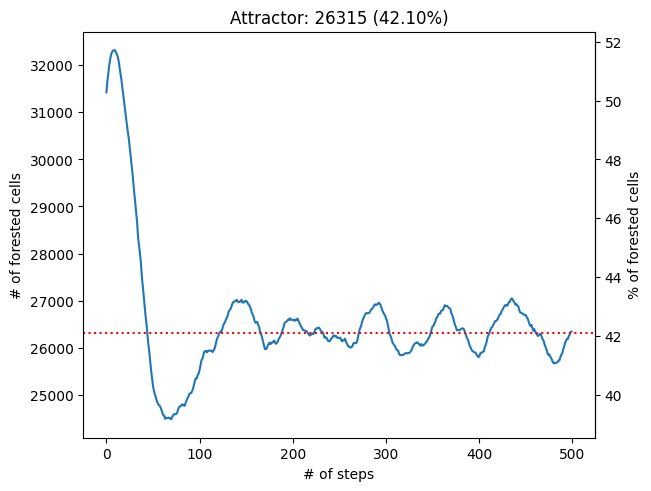

In [17]:
# Generate an elevation map
elevation = lin_slope(250)

# Generate an extended forest fire model
extended_ff = ExtForestFire(250, elev_map=elevation)

# Run a forest fire simulation to determine the steady state
fire_sim(extended_ff)

As can be seen from the series of plots above, the "steady state" of the extended model is approximately 42% forested compared to the simplified model which is approximately 32% forested (the same as we saw in Lab 7-10).

The surprising (to me) result is that the change in the "steady state" value appears to be entirely caused by the reduced probability of fire spreading. In other words, the introduction of the linearly sloped elevation map does not appear to affect the "steady state" of the model in any significant way.

But what if the slope of the terrain is increased...

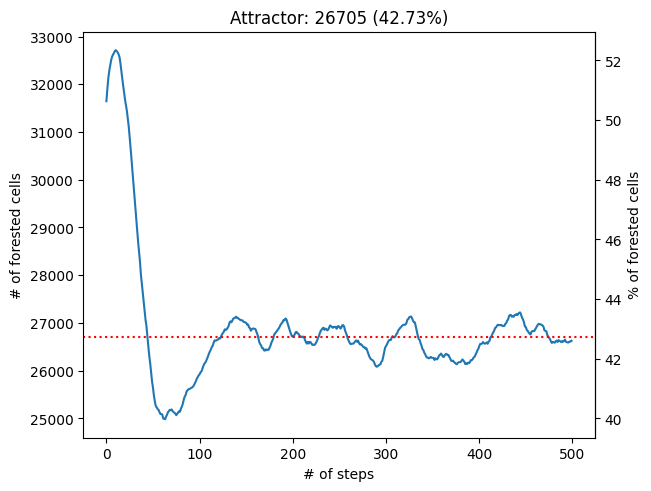

In [18]:
# Generate an elevation map with a slope of 3
elevation = lin_slope(250, slope=3)

# Generate an extended forest fire model
extended_ff_steep_slope = ExtForestFire(250, elev_map=elevation)

# Run a forest fire simulation to determine the steady state
fire_sim(extended_ff_steep_slope)

Once again, even with a steep slope, the "steady state" remains approximately 42% forested.

## Analysing the algorithm

With the forest fire model extended to account for changes in elevation, the `step()` method has become more complex. Python's `timeit` library can be utilized to get a sense of the increased complexity.

In [19]:
import timeit

In [20]:
# Setup code (only executed once)
setup = '''
from __main__ import ForestFire
model = ForestFire(250)
'''

# Main code to be timed (executed the specified number of times)
statement = "model.step()"

# Determine time to run simplified forest fire model
simple_time = timeit.timeit(stmt=statement, setup=setup, number=500)
print(simple_time)

3.2517674569999144


In [21]:
# Setup code (only executed once)
setup = '''
from __main__ import ExtForestFire
model = ExtForestFire(250)
'''

# Main code to be timed (executed the specified number of times)
statement = "model.step()"

# Determine time to run extended forest fire model
extended_time = timeit.timeit(stmt=statement, setup=setup, number=500)
print(extended_time)

93.03762307500006


As can be seen by the results above, the extended forest fire model took roughly 30x longer to run 500 timesteps -- not good.

Part of the issue is the fact that the `step()` method in the simplified forest fire model made use of NumPy's vector operations. Unfortunately, the updated fire spreading algorithm computes the ignition probabilities of each at-risk cell, which means computing the probability of catching fire from each neighbouring cell... Thus, the extended forest fire model is much more computationally expensive.

## Conclusions

The "steady state" of the extended forest fire model was determined to be approximately 42% forested which was greater than the simplified model developed in Labs 7-10. It was further determined that the increased "steady state" in the extended model appears to be a direct result of reducing the likelihood of a fire spreading to its cardinal neighbours and is not related to the introduction of a linearly sloping elevation map.

Further analysis of the extended forest fire model should be completed to confirm this conclusion. Additional elevation maps (e.g., a "mountain" or "valley") should be tested to see if they have any noticeable impact on the "steady state" of the model. Moreover, the patch size distribution and fractal dimension could also be computed and compared to the simplified model analyzed in Labs 7-10.

## Further Work

The model developed in this project could be further extended to include other factors that affect how a forest fire spreads (e.g., moisture, age, wind speed and direction, etc.). These factors could be implemented with additional model layers that are referenced in the `step()` method of the `ForestFire` class and incorporated into the ignition probability calculation for each at-risk cell.

However, before additional layers are added to the model, the complexity of the fire spreading algorithm should be reduced as much as possible. Otherwise the model could quickly become too computationally expensive to use.